# 1. initial Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import numpy for number array handling and represent rgb image pixel values
import numpy as np
from PIL import Image

#import tensorflow to use any tools needed for deep learning
import tensorflow as tf

#import keras api needed to implement deep learning techiques
from tensorflow import keras

#import libraries for visualization of data
import matplotlib.pyplot as plt

#Allow charts and graphics to display right below the page of browser setup
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-eg3xgexc because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [19]:
from conversion import ModelConverter

from model import AslClassification
from mlflow_tracker import MLFlowTracker, MLFlowTrainTrackingCallback
from metrics import plot_loss, plot_accuracy, print_confusion_matrix
from utils import show_worst_preds, crop_resize_image

# 2. Load and Split images along with applying Data Preprocessing and Data Augmentation

In [4]:
#paths to the train, validation and test image datasets 
data_path = '../datasets/asl_alphabet_train'

BATCH_SIZE = 32
CLASSES = ['I', 'K', 'L', 'O']
frozen_layers = 100
tracker = MLFlowTracker("asl-classification", f"default")
number_epocs = 10
tracker.track_config({'frozen_layers': frozen_layers, 'number_epocs': number_epocs, 'with_rotation': False, 'with_flip': False})

classifier = AslClassification(CLASSES, BATCH_SIZE, tracker)
classifier.load_dataset(data_path, data_path)

train_batches = classifier.train_batches
valid_batches = classifier.valid_batches
test_batches = classifier.test_batches

2024/05/02 16:55:11 WARNING mlflow.tracking.context.registry: Encountered unexpected error during resolving tags: 'getpwuid(): uid not found: 1000'


Found 12000 files belonging to 4 classes.
Using 10800 files for training.
Found 12000 files belonging to 4 classes.
Using 1200 files for validation.


# 3. Visualization of the images after Preprocessing

In [5]:
# plot images after applying VGG16 data preprocessing method
def plotImages(images):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")

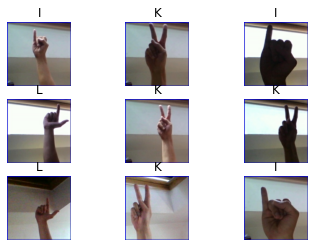

In [6]:
imgs, labels = next(iter(train_batches))
plotImages(imgs)

# 4. Building CNN Architecture

In [7]:
# set the input image size for proposed CNN model
classifier.build_model()

9412608/9406464 [==============================] - 0s 0us/step


# 5. Compile Model

In [8]:
# unfreeze the convolution base of the base model inorder to fine-tune which adapt these pre-trained weights 
# to work with the new dataset
classifier.base_model.trainable = True


# Freeze all the layers before the `frozen_layers` layer
for layer in classifier.base_model.layers[:frozen_layers]:
  layer.trainable = False

classifier.compile(learning_rate=0.0001)

# 6. Train Model

In [9]:
# train and fine-tune the model with appropriate number of epochs
model_details = classifier.fit(epochs=number_epocs)

Epoch 1/10
304/304 [==============================] - 79s 254ms/step - loss: 0.3220 - sparse_categorical_accuracy: 0.8809 - val_loss: 3.7588e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/10
304/304 [==============================] - 78s 255ms/step - loss: 0.0066 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.0027 - val_sparse_categorical_accuracy: 0.9992
Epoch 3/10
304/304 [==============================] - 78s 255ms/step - loss: 0.0039 - sparse_categorical_accuracy: 0.9996 - val_loss: 2.6227e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/10
304/304 [==============================] - 78s 255ms/step - loss: 0.0025 - sparse_categorical_accuracy: 0.9997 - val_loss: 4.4685e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/10
304/304 [==============================] - 78s 255ms/step - loss: 2.8909e-07 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3538e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/10
304/304 [==============================] - 77s 252ms/s

# 7. Visualization of Accuracy and Loss in Training and  Validation sets

In [10]:
loss = model_details.history['loss']
validation_loss = model_details.history['val_loss']

In [11]:
accuracy = model_details.history['sparse_categorical_accuracy']
validation_accuracy = model_details.history['val_sparse_categorical_accuracy']

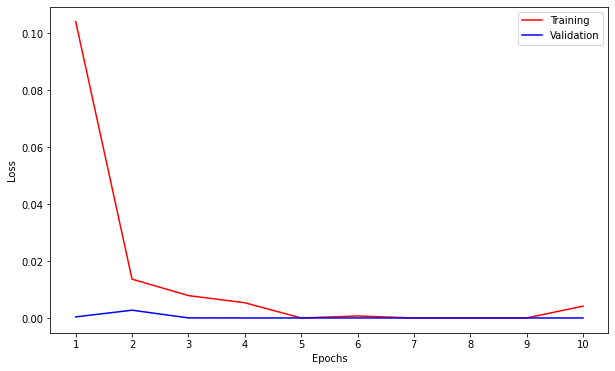

In [12]:
# plot the training and validation losses
plot_loss(loss, validation_loss)

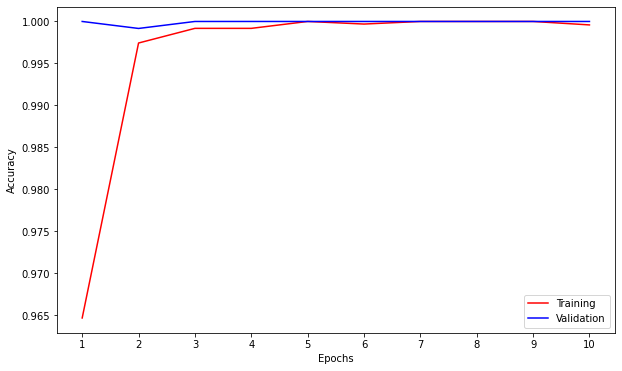

In [13]:
# plot the training and validation accuracy
plot_accuracy(accuracy, validation_accuracy)

# 8. Manual testing

Found 80 files belonging to 4 classes.


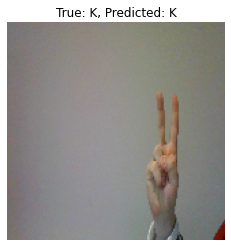

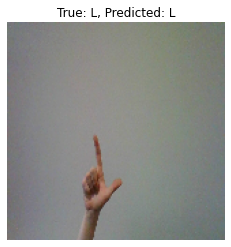

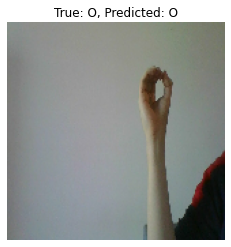

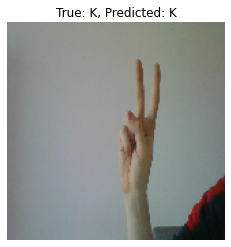

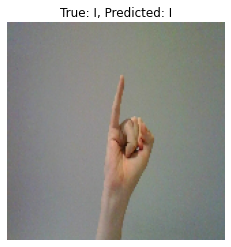

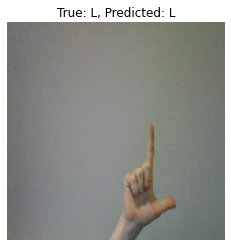

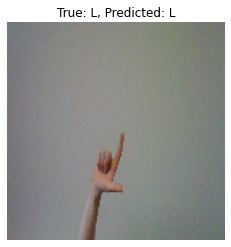

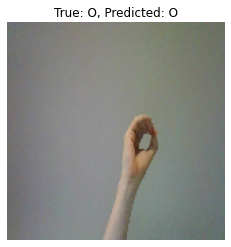

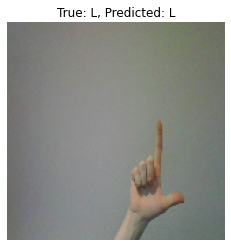

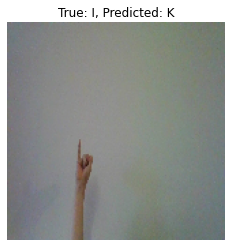

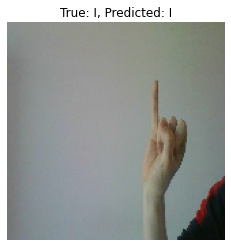

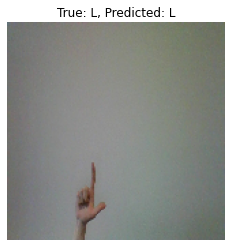

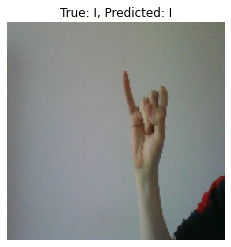

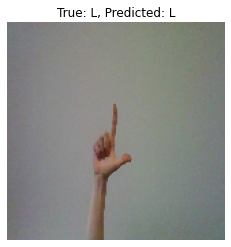

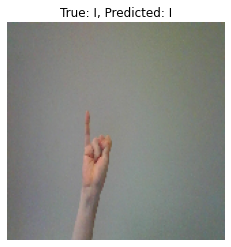

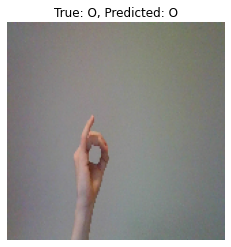

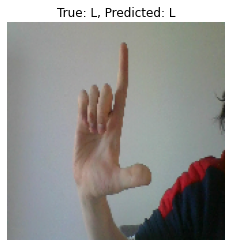

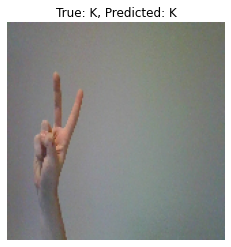

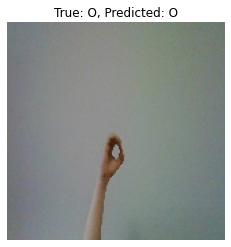

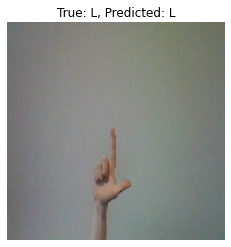

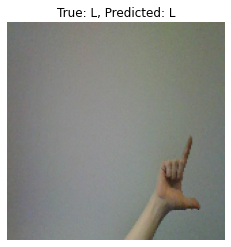

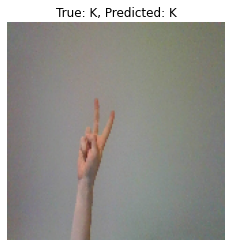

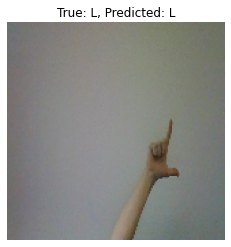

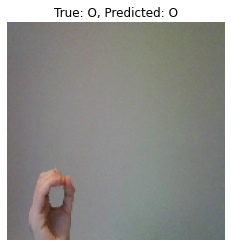

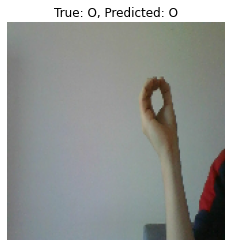

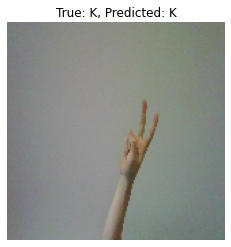

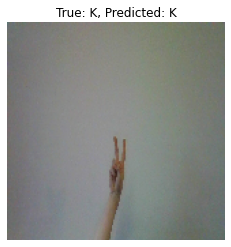

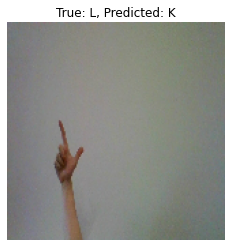

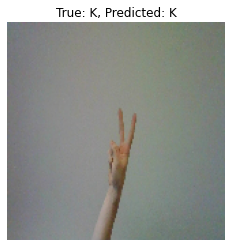

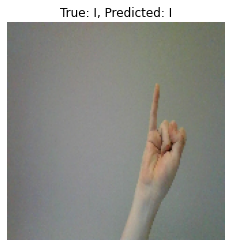

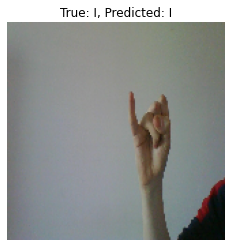

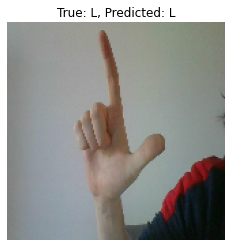

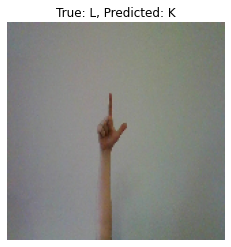

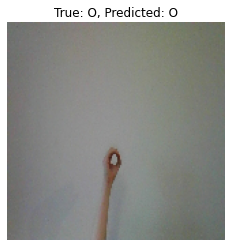

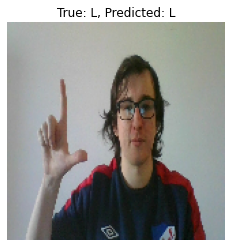

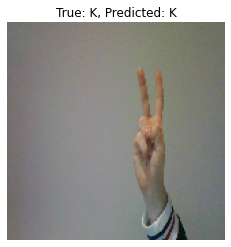

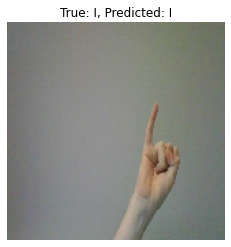

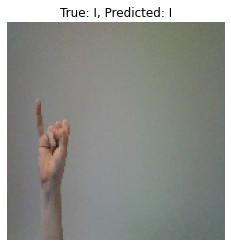

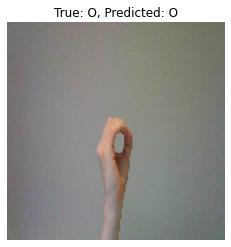

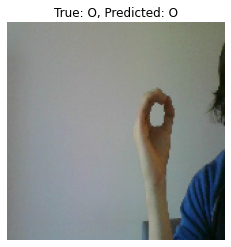

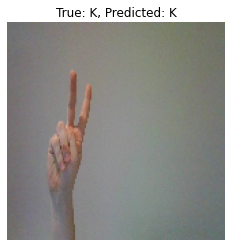

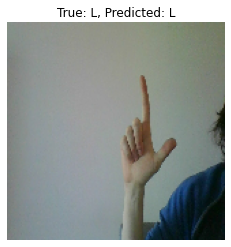

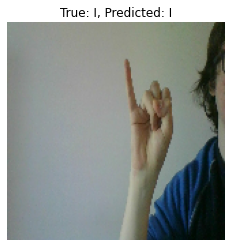

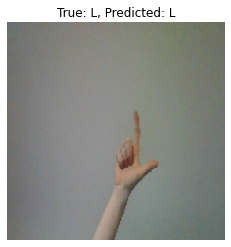

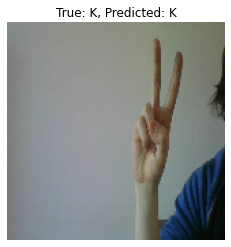

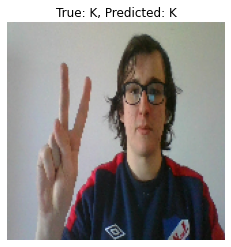

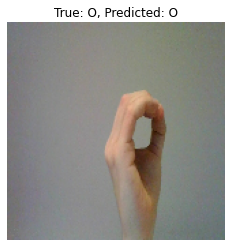

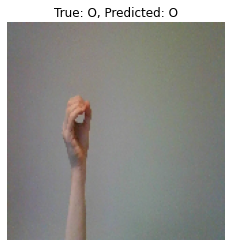

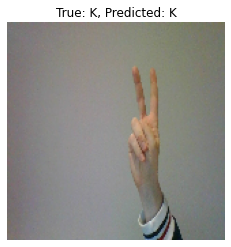

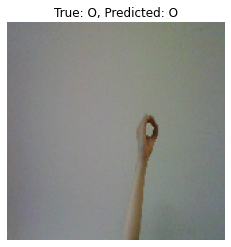

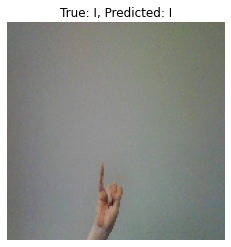

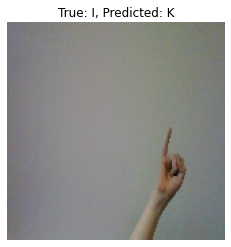

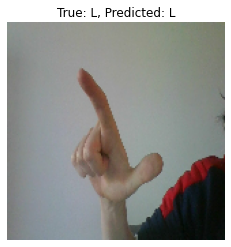

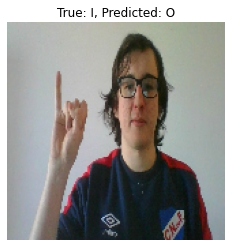

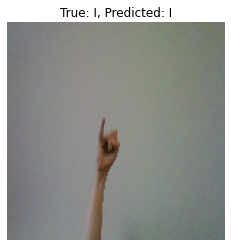

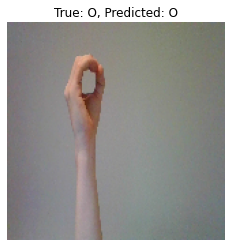

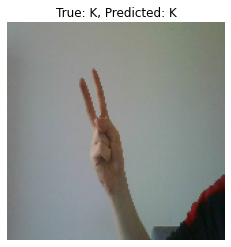

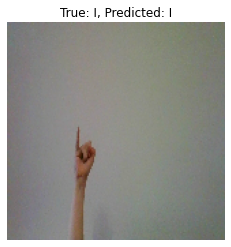

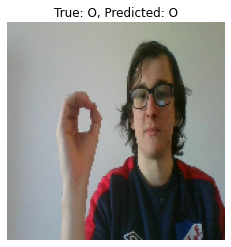

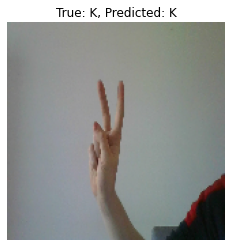

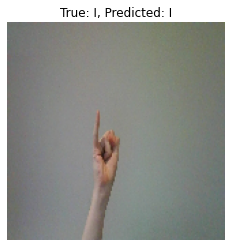

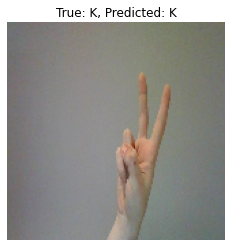

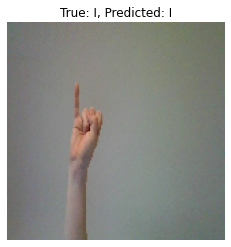

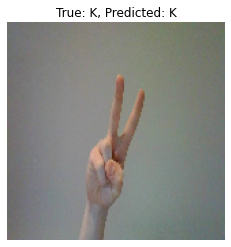

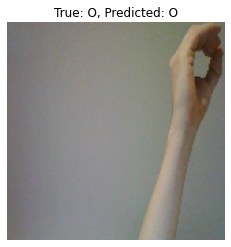

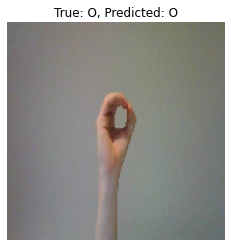

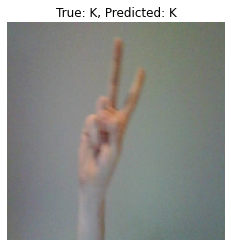

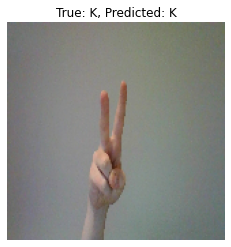

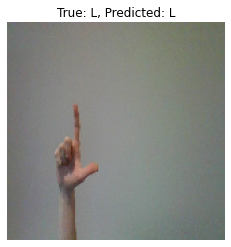

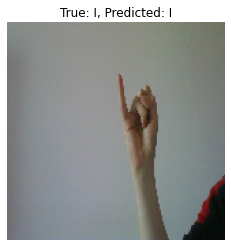

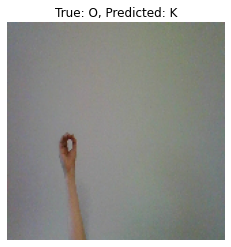

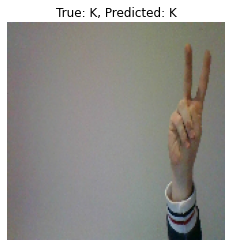

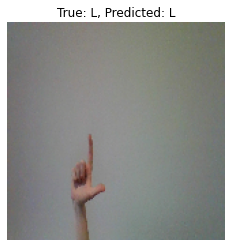

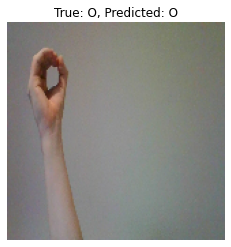

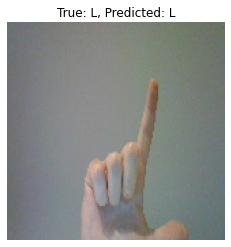

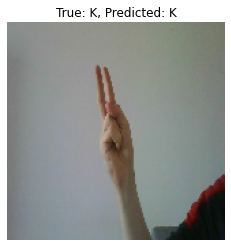

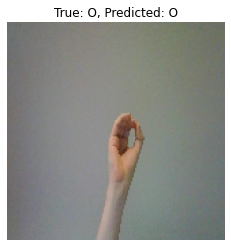

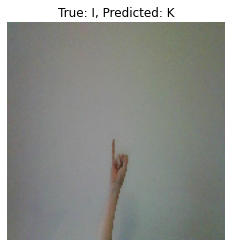

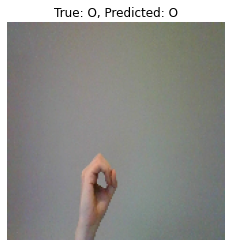

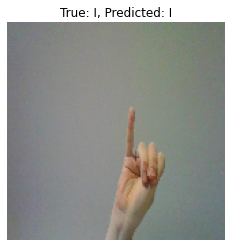

In [14]:
manual_test_dataset = tf.keras.preprocessing.image_dataset_from_directory('../datasets/manual_test/', 
                                                              image_size=classifier.img_size)
error_count = 0

for image_batch, label_batch in manual_test_dataset:
    # Get predictions for the batch of images
    predicted_manual_batch = classifier.predict(image_batch)
    
    # Iterate through individual images in the batch
    for i in range(len(image_batch)):
        image = image_batch[i].numpy()  # Convert the tensor to numpy array
        true_label = CLASSES[label_batch[i].numpy()]
        
        # Get the predicted class index for the current image
        predicted_class_index = np.argmax(predicted_manual_batch[i])
        predicted_label = CLASSES[predicted_class_index]
        
        # Display the image and its true/predicted class
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()
        if true_label != predicted_label:
            error_count += 1

In [15]:
print(f'Error count: {error_count}. Accuracy: f{1- error_count/80}')


Error count: 7. Accuracy: f0.9125


# 9. Track metrics

## Metrics for training dataset

In [16]:
train_loss, train_accuracy = classifier.evaluate(train_batches)
classifier.tracker.log_scalar_metric("accuracy-test", None, 0, train_accuracy)
classifier.tracker.log_scalar_metric("loss-test", None, 0, train_loss)

304/304 [==============================] - 46s 152ms/step - loss: 6.3722e-10 - sparse_categorical_accuracy: 1.0000


## Metrics for validation dataset

In [17]:
classifier.tracker.log_scalar_metric("accuracy-validation", None, 0, model_details.history['val_sparse_categorical_accuracy'][-1])
classifier.tracker.log_scalar_metric("loss-validation", None, 0, model_details.history['val_loss'][-1])

# 10. Save and track model

In [18]:
classifier.model.export('../models/tf_model/1')
classifier.tracker.track_artifacts('../models/tf_model/1')

AttributeError: 'Functional' object has no attribute 'export'

# Finish tracker run

In [ ]:
classifier.tracker.finish_run()